In [26]:
! pip install sqlalchemy


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
! pip install pyodbc

   ---------------------------------------- 0.0/68.9 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/68.9 kB ? eta -:--:--
   ----------- ---------------------------- 20.5/68.9 kB 165.2 kB/s eta 0:00:01
   ----------------- ---------------------- 30.7/68.9 kB 220.2 kB/s eta 0:00:01
   ---------------------------------------- 68.9/68.9 kB 340.9 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine

In [23]:
df = pd.read_csv("C:\\Users\\PALASH\\Downloads\\archive (8)\\loan.csv")

C:\Users\PALASH\AppData\Local\Temp\ipykernel_9316\3831228726.py:1: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\PALASH\\Downloads\\archive (8)\\loan.csv")


In [24]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

In [25]:
df = df[(df['issue_d'].dt.year >= 2014) & (df['issue_d'].dt.year <= 2018)]

In [26]:
df = df.sample(n=20000, random_state=42).reset_index(drop=True)

In [31]:
df.shape

(20000, 145)

In [32]:
# Drop rows with nulls in critical columns
df = df.dropna(subset=['loan_amnt', 'issue_d', 'loan_status'])

# Remove % symbol from interest rate and revol_util
df['int_rate'] = df['int_rate'].astype(str).str.replace('%', '').astype(float)
df['revol_util'] = df['revol_util'].astype(str).str.replace('%', '').astype(float)

# Clean term column
df['term'] = df['term'].str.extract('(\d+)').astype(int)

# Clean employment length
df['emp_length'] = df['emp_length'].replace({
    '10+ years': '10', '< 1 year': '0', 'n/a': 'Unknown', None: 'Unknown'
}).fillna('Unknown')

# Fill missing values
df['debt_settlement_flag'] = df['debt_settlement_flag'].fillna('N')
df['settlement_percentage'] = df['settlement_percentage'].fillna(0)
df['recoveries'] = df['recoveries'].fillna(0)
df['last_pymnt_amnt'] = df['last_pymnt_amnt'].fillna(0)
df['delinq_2yrs'] = df['delinq_2yrs'].fillna(0)

# Remove extreme outliers
df = df[df['annual_inc'] < 1_000_000]
df = df[df['dti'] < 50]

# Rename columns for clarity in Power BI
df.rename(columns={
    'loan_amnt': 'loan_amount',
    'funded_amnt': 'funded_amount',
    'installment': 'installment',
    'term': 'term_months',
    'int_rate': 'interest_rate',
    'emp_length': 'employment_length',
    'home_ownership': 'home_ownership',
    'annual_inc': 'annual_income',
    'dti': 'dti',
    'purpose': 'loan_purpose',
    'addr_state': 'province',
    'application_type': 'application_type',
    'verification_status': 'income_verified',
    'total_pymnt': 'total_payment',
    'last_pymnt_amnt': 'last_payment_amount',
    'recoveries': 'recovery_amount',
    'revol_util': 'revolving_utilization',
    'delinq_2yrs': 'delinquencies_2yrs',
    'debt_settlement_flag': 'debt_settled',
    'settlement_percentage': 'settlement_percentage',
    'grade': 'grade',
    'sub_grade': 'sub_grade',
    'loan_status': 'loan_status',
    'issue_d': 'issue_date',
    'last_pymnt_d': 'last_payment_date'
}, inplace=True)

# Final DataFrame ready for Azure
df_final = df.copy()


In [33]:
df_final.head()

,id,member_id,loan_amount,funded_amount,funded_amnt_inv,term_months,interest_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settled,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,21000,21000,21000.0,36,12.59,703.44,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,0.0,NaN
1,NaN,NaN,7600,7600,7600.0,36,18.06,274.99,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,0.0,NaN
2,NaN,NaN,15000,15000,15000.0,36,15.31,522.26,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,0.0,NaN
3,NaN,NaN,18000,18000,18000.0,36,10.41,584.29,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,0.0,NaN
4,NaN,NaN,28600,28600,28600.0,60,20.75,769.71,E,E2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,0.0,NaN


In [34]:
required_columns = [
    'loan_amount', 'funded_amount', 'installment', 'term_months', 'interest_rate',
    'grade', 'sub_grade', 'loan_status', 'issue_date', 'last_payment_date',
    'employment_length', 'home_ownership', 'annual_income', 'dti',
    'loan_purpose', 'province', 'application_type', 'income_verified',
    'total_payment', 'last_payment_amount', 'recovery_amount', 'revolving_utilization',
    'delinquencies_2yrs', 'debt_settled', 'settlement_percentage'
]

df_final = df[required_columns].copy()

In [35]:
df_final

,loan_amount,funded_amount,installment,term_months,interest_rate,grade,sub_grade,loan_status,issue_date,last_payment_date,...,province,application_type,income_verified,total_payment,last_payment_amount,recovery_amount,revolving_utilization,delinquencies_2yrs,debt_settled,settlement_percentage
0,21000,21000,703.44,36,12.59,C,C2,Fully Paid,2015-12-01,Jun-2018,...,FL,Individual,Verified,25156.233983,4785.85,0.00,82.0,0.0,N,0.0
1,7600,7600,274.99,36,18.06,D,D2,Current,2017-12-01,Feb-2019,...,KY,Joint App,Source Verified,3848.320000,274.99,0.00,71.9,0.0,N,0.0
2,15000,15000,522.26,36,15.31,C,C5,Fully Paid,2016-03-01,Nov-2016,...,NC,Individual,Verified,16294.040000,13131.58,0.00,60.0,5.0,N,0.0
3,18000,18000,584.29,36,10.41,B,B3,Fully Paid,2018-04-01,Sep-2018,...,NJ,Individual,Source Verified,18845.994234,16529.65,0.00,72.6,0.0,N,0.0
4,28600,28600,769.71,60,20.75,E,E2,Current,2016-03-01,Feb-2019,...,FL,Individual,Source Verified,26906.880000,769.71,0.00,40.3,0.0,N,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,10000,10000,313.18,36,7.96,A,A5,Fully Paid,2018-04-01,Dec-2018,...,MD,Individual,Not Verified,10395.882140,1827.46,0.00,32.3,0.0,N,0.0
19996,12000,12000,385.35,36,9.67,B,B1,Fully Paid,2014-02-01,Oct-2014,...,CT,Individual,Not Verified,12707.410634,10009.96,0.00,27.7,0.0,N,0.0
19997,5000,5000,169.66,36,13.49,C,C2,Charged Off,2016-07-01,Nov-2017,...,UT,Individual,Verified,3133.940000,169.66,423.13,66.5,0.0,N,0.0
19998,10000,10000,314.48,36,8.24,B,B1,Fully Paid,2017-04-01,May-2018,...,VA,Individual,Not Verified,10772.901397,7008.30,0.00,64.1,0.0,N,0.0


In [36]:
df_final.shape

(19833, 25)

In [37]:
df_final.columns

Index(['loan_amount', 'funded_amount', 'installment', 'term_months',
       'interest_rate', 'grade', 'sub_grade', 'loan_status', 'issue_date',
       'last_payment_date', 'employment_length', 'home_ownership',
       'annual_income', 'dti', 'loan_purpose', 'province', 'application_type',
       'income_verified', 'total_payment', 'last_payment_amount',
       'recovery_amount', 'revolving_utilization', 'delinquencies_2yrs',
       'debt_settled', 'settlement_percentage'],
      dtype='object')

In [38]:
df_final

,loan_amount,funded_amount,installment,term_months,interest_rate,grade,sub_grade,loan_status,issue_date,last_payment_date,...,province,application_type,income_verified,total_payment,last_payment_amount,recovery_amount,revolving_utilization,delinquencies_2yrs,debt_settled,settlement_percentage
0,21000,21000,703.44,36,12.59,C,C2,Fully Paid,2015-12-01,Jun-2018,...,FL,Individual,Verified,25156.233983,4785.85,0.00,82.0,0.0,N,0.0
1,7600,7600,274.99,36,18.06,D,D2,Current,2017-12-01,Feb-2019,...,KY,Joint App,Source Verified,3848.320000,274.99,0.00,71.9,0.0,N,0.0
2,15000,15000,522.26,36,15.31,C,C5,Fully Paid,2016-03-01,Nov-2016,...,NC,Individual,Verified,16294.040000,13131.58,0.00,60.0,5.0,N,0.0
3,18000,18000,584.29,36,10.41,B,B3,Fully Paid,2018-04-01,Sep-2018,...,NJ,Individual,Source Verified,18845.994234,16529.65,0.00,72.6,0.0,N,0.0
4,28600,28600,769.71,60,20.75,E,E2,Current,2016-03-01,Feb-2019,...,FL,Individual,Source Verified,26906.880000,769.71,0.00,40.3,0.0,N,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,10000,10000,313.18,36,7.96,A,A5,Fully Paid,2018-04-01,Dec-2018,...,MD,Individual,Not Verified,10395.882140,1827.46,0.00,32.3,0.0,N,0.0
19996,12000,12000,385.35,36,9.67,B,B1,Fully Paid,2014-02-01,Oct-2014,...,CT,Individual,Not Verified,12707.410634,10009.96,0.00,27.7,0.0,N,0.0
19997,5000,5000,169.66,36,13.49,C,C2,Charged Off,2016-07-01,Nov-2017,...,UT,Individual,Verified,3133.940000,169.66,423.13,66.5,0.0,N,0.0
19998,10000,10000,314.48,36,8.24,B,B1,Fully Paid,2017-04-01,May-2018,...,VA,Individual,Not Verified,10772.901397,7008.30,0.00,64.1,0.0,N,0.0


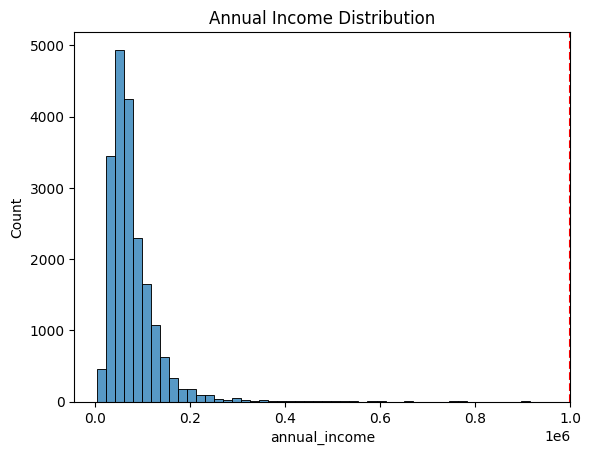

In [39]:
sns.histplot(df_final['annual_income'], bins=50)
plt.axvline(1_000_000, color='red', linestyle='--')
plt.title("Annual Income Distribution")
plt.show()

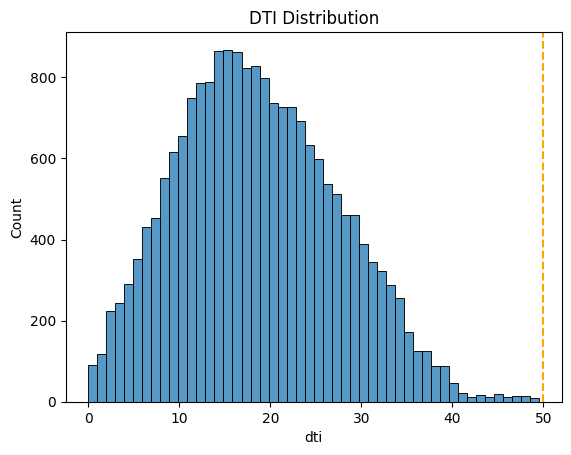

In [40]:
sns.histplot(df_final['dti'], bins=50)
plt.axvline(50, color='orange', linestyle='--')
plt.title("DTI Distribution")
plt.show()

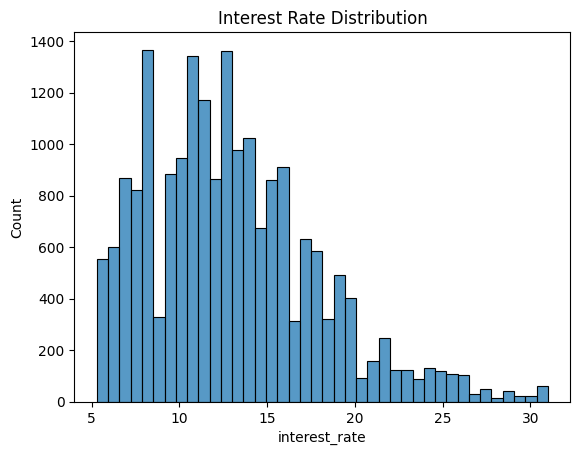

In [41]:
sns.histplot(df_final['interest_rate'], bins=40)
plt.title("Interest Rate Distribution")
plt.show()

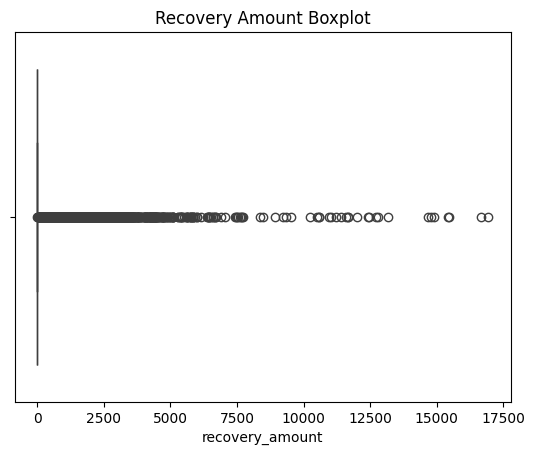

In [42]:
sns.boxplot(x=df_final['recovery_amount'])
plt.title("Recovery Amount Boxplot")
plt.show()

In [43]:
df_final = df_final[df_final['annual_income'] < 1_000_000]
df_final = df_final[df_final['dti'] < 50]
df_final = df_final[(df_final['interest_rate'] > 0) & (df_final['interest_rate'] <= 30)]

cap = df_final['recovery_amount'].quantile(0.99)
df_final['recovery_amount'] = df_final['recovery_amount'].clip(upper=cap)

In [44]:
df_final.shape

(19757, 25)

In [45]:
server = 'loan-sql-server.database.windows.net'
database = 'LoanAnalyticsDB'
username = 'palash_admin'
password = 'Project30'
driver = 'ODBC Driver 17 for SQL Server'

# Create connection string
connection_string = f"mssql+pyodbc://{username}:{password}@{server}:1433/{database}?driver={driver}"
engine = create_engine(connection_string)

# Push cleaned final dataset to Azure SQL
df_final.to_sql("loan_data_final", con=engine, if_exists="replace", index=False)

print("Push successful! Data is now in Azure SQL")

Push successful! Data is now in Azure SQL
